# CC Scheme

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from obspy import UTCDateTime, read_inventory
import os
import xcorr

In [2]:
%matplotlib notebook

In [3]:
client = xcorr.Client(sds_root='/Users/psmets/Documents/Research/_data/WaveformArchive')

In [4]:
# general parameters
sampling_rate = 50.
window_length = 86400. # 24h
window_overlap = 21./24. # 3h shift
clip_lag = pd.to_timedelta((0,6),unit='h')
poi = {'name': 'MVC', 'latitude': -25.887, 'longitude': -177.188, 'elevation': 0., 'local_depth': 132.}

attrs = {
    'title': 'Monowai Volcanic Centre',
    'institution': 'Delft University of Technology, Department of Geoscience and Engineering',
    'author': 'Pieter Smets - P.S.M.Smets@tudelft.nl',
    'source': 'CTBTO/IMS hydroacoustic data and IRIS/USGS seismic data',
}

# stream preprocess operations (sequential!)
preprocess = {
    'BHZ': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
        # ('running_rms', {}),
    ],
    'BHR': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_response', {'output': 'VEL'}),
        ('rotate', {'method':'->ZNE'}),
        ('rotate', {'method':'NE->RT', 'back_azimuth':250.39 }),
        ('select', {'channel':'BHR'}),
        ('filter', { 'type': 'highpass', 'freq': 3. }),
        ('interpolate', {'sampling_rate': 50, 'method':'lanczos', 'a':20 }),
        ('filter', { 'type': 'lowpass', 'freq': 20. }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', { 'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
        # ('running_rms', {}),
    ],
    'EDH': [
        ('merge', { 'method': 1, 'fill_value': 'interpolate', 'interpolation_samples':0 }),
        ('filter', {'type':'highpass','freq':.05}),
        ('detrend', { 'type': 'demean' }),
        ('remove_sensitivity', {}),
        # ('remove_response', {}),
        ('filter', { 'type': 'bandpass', 'freqmin': 3., 'freqmax': 20. }),
        ('decimate', { 'factor': 5 }),
        ('trim', {}),
        ('detrend', { 'type': 'demean' }),
        ('taper', {'type': 'cosine', 'max_percentage': 0.05, 'max_length': 30.}),
        # ('running_rms', {}),
    ],
}

Inventory created at 2020-04-03T07:31:47.660774Z
	Created by: ObsPy 1.1.0
		    https://www.obspy.org
	Sending institution: IRIS-DMC,sc3ml import (IRIS-DMC,ObsPy Inventory)
	Contains:
		Networks (5):
			IM (2x), IU (3x)
		Stations (5):
			IM.H03S1 (Juan Fernandez Island)
			IM.H10N1 (ASCENSION, United States of America)
			IU.RAR (Rarotonga, Cook Islands) (3x)
		Channels (5):
			IM.H03S1..EDH, IM.H10N1..EDH, IU.RAR.10.BHZ, IU.RAR.10.BH1, 
			IU.RAR.10.BH2


<IPython.core.display.Javascript object>


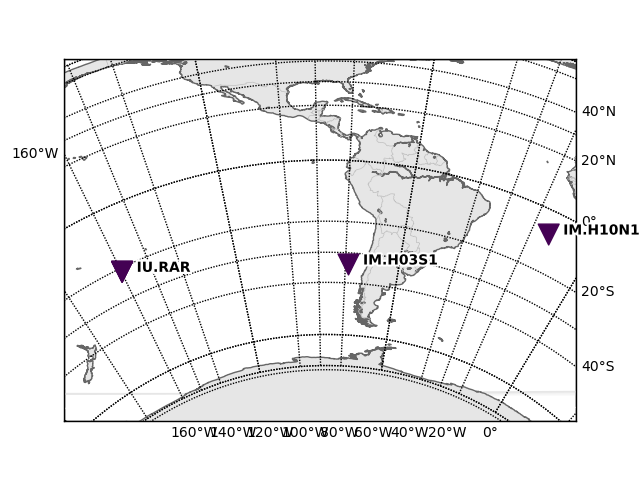

In [5]:
pairs = [
    'IM.H10N1..EDH-IU.RAR.10.BHZ',
    'IM.H10N1..EDH-IU.RAR.10.BHR',
    'IM.H03S1..EDH-IU.RAR.10.BHZ',
    'IM.H03S1..EDH-IU.RAR.10.BHR',
]
times = pd.date_range('2015-01-15', '2015-01-18', freq='1D')

inv = xcorr.util.get_pair_inventory(pairs, read_inventory('Monowai.xml'), times)
# inv = read_inventory('Monowai.xml')

print(inv)
fig = inv.plot(color=0., projection='local')

## Correlate one day of data

In [6]:
pair = pairs[1]
time = times[0]

In [7]:
ds = xcorr.init(
    pair=pair,
    starttime=time,
    endtime=time + pd.offsets.DateOffset(1), 
    attrs=attrs,
    preprocess=preprocess, 
    sampling_rate=sampling_rate, 
    window_length=window_length, 
    window_overlap=window_overlap, 
    clip_lag=clip_lag,
    unbiased_cc=False,
    inventory=inv,
    stationary_poi=poi,
)

In [8]:
ds

<xarray.Dataset>
Dimensions:      (lag: 1080000, pair: 1, time: 8)
Coordinates:
  * pair         (pair) object 'IM.H10N1..EDH-IU.RAR.10.BHR'
  * time         (time) datetime64[ns] 2015-01-15 ... 2015-01-15T21:00:00
  * lag          (lag) timedelta64[ns] 00:00:00 ... 05:59:59.980000
Data variables:
    distance     (pair) float64 1.399e+04
    status       (pair, time) int8 0 0 0 0 0 0 0 0
    pair_offset  (pair, time) timedelta64[ns] 00:00:00 00:00:00 ... 00:00:00
    time_offset  (pair, time) timedelta64[ns] 00:00:00 00:00:00 ... 00:00:00
    cc           (pair, time, lag) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    title:                 Monowai Volcanic Centre Crosscorrelations - 2015.015
    institution:           Delft University of Technology, Department of Geos...
    author:                Pieter Smets - P.S.M.Smets@tudelft.nl
    source:                CTBTO/IMS hydroacoustic data and IRIS/USGS seismic...
    history:               Created @ 2020-04-03 07:31:51.688068
    references:            Bendat, J. Samuel, & Piersol, A. Gerald. (1971). R...
    comment:               n/a
    Conventions:           CF-1.9
    xcorr_version:         0.1.dev101+ge822bd0
    dependencies_version:  json-2.0.9, numpy-1.16.4, obspy-1.1.0, pandas-1.0....
    sha256_hash_metadata:  9b9edeeace420256c4a5709423fd4c4bef813e5f3358b4da9b...

In [11]:
xcorr.process(ds, inventory=inv, client=client)

IM.H10N1..EDH-IU.RAR.10.BHR 2015-01-15T00:00:00: Waveforms. Hash. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHR 2015-01-15T03:00:00: Waveforms. Hash. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHR 2015-01-15T06:00:00: Waveforms. Hash. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHR 2015-01-15T09:00:00: Waveforms. Hash. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHR 2015-01-15T12:00:00: Waveforms. Hash. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHR 2015-01-15T15:00:00: Waveforms. Hash. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHR 2015-01-15T18:00:00: Waveforms. Hash. CC. Done.
IM.H10N1..EDH-IU.RAR.10.BHR 2015-01-15T21:00:00: Waveforms. Hash. CC. Done.


In [12]:
xcorr.write(ds, 'test.nc')

Write dataset as "test.nc": Close. Hash. pair 88bb3ec072fb695e686616531edcfc03f1e46b0b64a49edde10c73795d53813f
time 8b414f7394631cddc355749f31ba6ab69fb1378382a1f5bbc2a502bbb76bd53a
lag 86c5f42245ff2c908cf6ecb241ab45c38b8aa195cdde6ed7fb931f967c94a5d8
distance 9b6572fa94a9336f52337683e0a2e2f9d55100f88833e6eb9fb1d24518db7a06
status ff12a308e0d2ef8390ae4de457df92838e61a243d6778b621fe5e6654b99daa1
hash 830f6814e72f13d5d9464f7fb39cc76126c84485f015b9340ca10cfa61d42ca3
pair_offset 7c79856ae782f5f68b5d7be5a2371e2bb79ca8d016b01ef352a91e396394e71f
time_offset d2c8343234719bd1e8758bd21d94196f1a650242c6aa643e9110854bdcfb4731
cc 0e2ed36fa4b6f3853450d740b06902801abce6ffc7ebab30bb08e2c0cca9910d
Dataset hash 0e2ed36fa4b6f3853450d740b06902801abce6ffc7ebab30bb08e2c0cca9910d
To temporary netcdf. Replace. Done.


In [13]:
ds1 = xcorr.read('test.nc', debug=True)

test.nc #(status==1): 8 of 8


### A whole period

In [ ]:
def filename(pair:str,time:pd.datetime):
    return '{pair}.{y:04d}.{d:03d}.nc'.format(pair=pair,y=time.year,d=time.dayofyear)
dest = '/Users/psmets/Documents/Research/_studies/_hydro/monowai_remote/tests/full'

In [ ]:
warnings.filterwarnings('ignore') # no warnings of duplicate inventory items

for pair in pairs:
    print('---------------------------')
    print(pair)
    print('---------------------------')
    for time in times:
        ncfile = os.path.join(dest,pair,filename(pair, time))
        ds = False
        if os.path.isfile(ncfile):
            ds = xr.open_dataset(ncfile)
            if ds and np.all(ds.status.values == 1):
                ds.close()
                continue
        if not ds:
            ds = xcorr.init_dataset(
                pair=pair,
                starttime=time,
                endtime=time + pd.offsets.DateOffset(1), 
                attrs=attrs,
                preprocess=preprocess, 
                sampling_rate=sampling_rate, 
                window_length=window_length, 
                window_overlap=window_overlap, 
                clip_lag=clip_lag,
                unbiased_cc=False,
                inventory=inv,
                stationary_poi=poi,
            )
        try:
            xcorr.cc_dataset(
                ds,
                inventory=inv.select(
                    starttime=UTCDateTime(time),
                    endtime=UTCDateTime(time + pd.offsets.DateOffset(1))
                ),
                client=client,
                retry_missing=True,
            )
        except (KeyboardInterrupt, SystemExit):
            raise
        except Exception as e:
            print('An error occurred. Save and continue next timestep or pair.')
            print('Error:')
            print(e)
        if ds and np.any(ds.status.values != 0):
            xcorr.write_dataset(ds,ncfile)